In [1]:
import torch
import matplotlib.pyplot as plt
from model_builder import ViT
from data_setup import create_dataloader
from metrics import accuracy_fn, EarlyStopping

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
""" Create dataloader """
root_path = 'processed_data/'
train_ratio = 0.8
batch_size = 64
train_loader, val_loader, classes = create_dataloader(root_path, train_ratio, batch_size)

""" Create Model """
input_chanel = 3
output_chanel = 32
n_head = 1
n_expansion = 4
n_layer = 1
num_classes = len(classes)
model = ViT(input_chanel, output_chanel, n_head, n_expansion, n_layer, num_classes).to(device)

In [3]:
""" Create Metrics """
epochs = 60
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=5, delta=0.01, verbose=True)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

""" Training model """
result = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': []
}

In [4]:
for epoch in range(epochs):
    # ---------------------------------------- Training ----------------------------------------
    train_loss = 0
    train_acc = 0
    for batch, (X, y) in enumerate(train_loader):
        model.train()
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc += accuracy_fn(torch.softmax(y_pred, dim=1).argmax(dim=1), y)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # ---------------------------------------- Validation ----------------------------------------
    val_loss = 0
    val_acc = 0
    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(val_loader):
            X, y = X.to(device), y.to(device)
            # Forward pass
            y_pred = model(X)
            # Calculate validation loss and accuracy
            val_loss += criterion(y_pred, y).item()
            val_acc += accuracy_fn(torch.softmax(y_pred, dim=1).argmax(dim=1), y)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    print(f"Epoch: {epoch + 1}/{epochs} - Training Loss: {train_loss:.2f} - Training Accuracy: {train_acc:.2f} - Validation Loss: {val_loss:.2f} - Validation Accuracy: {val_acc:.2f}")
    result['train_acc'].append(train_acc)
    result['train_loss'].append(train_loss)
    result['val_acc'].append(val_acc)
    result['val_loss'].append(val_loss)
    # ---------------------------------------- Learning rate Schedule ----------------------------------------
    lr_scheduler.step(val_loss)
    # ---------------------------------------- Check EarlyStopping ----------------------------------------
    if early_stopping(val_loss):
        break

Epoch: 1/60 - Training Loss: 2.84 - Training Accuracy: 0.12 - Validation Loss: 2.78 - Validation Accuracy: 0.15
Epoch: 2/60 - Training Loss: 2.62 - Training Accuracy: 0.32 - Validation Loss: 2.54 - Validation Accuracy: 0.33
Epoch: 3/60 - Training Loss: 2.24 - Training Accuracy: 0.48 - Validation Loss: 2.19 - Validation Accuracy: 0.42
Epoch: 4/60 - Training Loss: 1.80 - Training Accuracy: 0.63 - Validation Loss: 1.73 - Validation Accuracy: 0.63
Epoch: 5/60 - Training Loss: 1.38 - Training Accuracy: 0.77 - Validation Loss: 1.35 - Validation Accuracy: 0.75
Epoch: 6/60 - Training Loss: 1.00 - Training Accuracy: 0.86 - Validation Loss: 1.08 - Validation Accuracy: 0.80
Epoch: 7/60 - Training Loss: 0.71 - Training Accuracy: 0.92 - Validation Loss: 0.86 - Validation Accuracy: 0.85
Epoch: 8/60 - Training Loss: 0.51 - Training Accuracy: 0.95 - Validation Loss: 0.65 - Validation Accuracy: 0.89
Epoch: 9/60 - Training Loss: 0.35 - Training Accuracy: 0.97 - Validation Loss: 0.53 - Validation Accurac

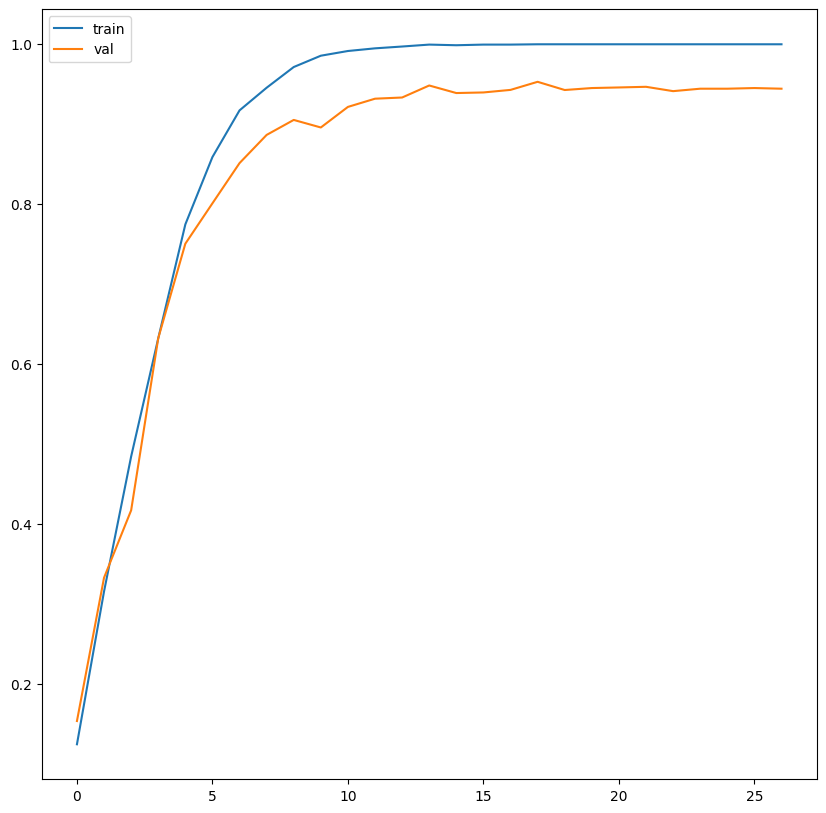

In [7]:
plt.figure(1, figsize=(10, 10))
plt.plot([i.cpu().detach().numpy() for i in result['train_acc']])
plt.plot([i.cpu().detach().numpy() for i in result['val_acc']])
plt.legend(['train', 'val'])
plt.show()

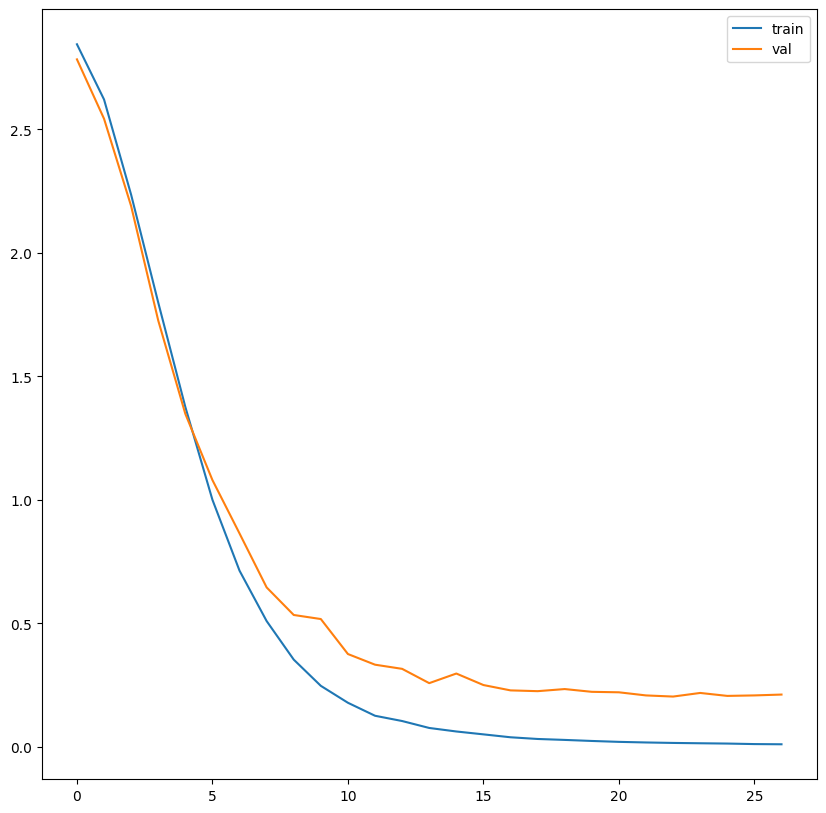

In [9]:
plt.figure(2, figsize=(10, 10))
plt.plot(result['train_loss'])
plt.plot(result['val_loss'])
plt.legend(['train', 'val'])
plt.show()

In [11]:
torch.save({
    'model_state_dict': model.state_dict(),
    'class': classes
}, 'checkpoint_1.pth.tar')